# Garbage Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%load_ext tensorboard

## Carregando e separando os dados

In [4]:
!ls "/content/drive/MyDrive/Colab/Garbage classification/Garbage classification"

cardboard  glass  metal  paper	plastic  trash


In [5]:
base_path = '/content/drive/MyDrive/Colab/Garbage classification/Garbage classification'

df_all = pd.DataFrame()
for dirname, _, filenames in os.walk(base_path):
    paths = [dirname + '/' + filename for filename in filenames if '.jpg' in filename]
    folder_name = os.path.split(dirname)[-1]
    df_all = pd.concat([df_all, pd.DataFrame({'path': paths, 'label': folder_name})], ignore_index=True)

df_all

,path,label
0,/content/drive/MyDrive/Colab/Garbage classific...,metal
1,/content/drive/MyDrive/Colab/Garbage classific...,metal
2,/content/drive/MyDrive/Colab/Garbage classific...,metal
3,/content/drive/MyDrive/Colab/Garbage classific...,metal
4,/content/drive/MyDrive/Colab/Garbage classific...,metal
...,...,...
2522,/content/drive/MyDrive/Colab/Garbage classific...,trash
2523,/content/drive/MyDrive/Colab/Garbage classific...,trash
2524,/content/drive/MyDrive/Colab/Garbage classific...,trash
2525,/content/drive/MyDrive/Colab/Garbage classific...,trash


In [6]:
# Número de imagens por classe (dataset desbalanceado)
df_all['label'].value_counts().sort_index()

cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137
Name: label, dtype: int64

In [7]:
# Número de classes
n_classes = len(df_all['label'].unique())
n_classes

6

In [8]:
# Lista das classes
classes = list(df_all['label'].unique())
classes

['metal', 'paper', 'plastic', 'glass', 'cardboard', 'trash']

In [9]:
# Reduzindo o dataframe para 125 imagens por classe
df = df_all.head(0)

for c in classes:
  subset = df_all[df_all['label'] == c]
  subset = subset.sample(125, random_state=0)
  df = pd.concat([df, subset], ignore_index=True)

df['label'].value_counts()


metal        125
paper        125
plastic      125
glass        125
cardboard    125
trash        125
Name: label, dtype: int64

In [10]:
# Separando conjunto de treinamento, validação e teste
df_train, df_test = train_test_split(df, test_size=25*n_classes, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_train, test_size=25*n_classes, stratify=df_train['label'], random_state=42)

df_train_small, _ = train_test_split(df_train, train_size=25*n_classes, stratify=df_train['label'], random_state=42)

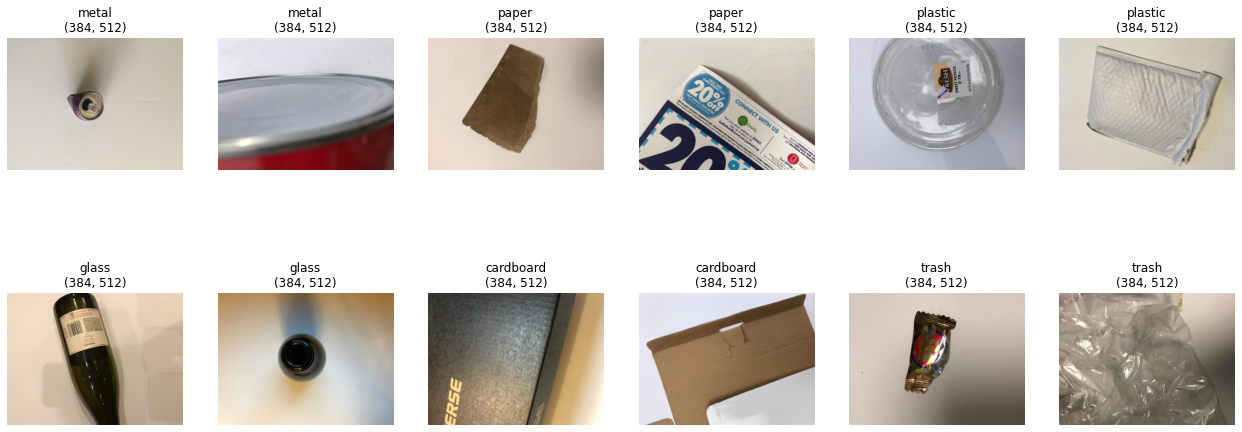

In [11]:
plt.figure(figsize=(22,18))
for i, label in enumerate(classes):
  for j in range(2):
    plt.subplot(4,6, 2*i+j+1)
    img = plt.imread(df_train['path'][df['label'] ==  label].iloc[j])
    plt.imshow(img)
    plt.title(f"{label}\n{img.shape[:2]}")
    plt.axis("off")

In [12]:
# Função para preparar o tf.data.Dataset
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE 


def create_dataset(df, img_size, batch_size):
  paths = df['path']
  labels = df['label'].map(classes.index) # ordinal encoder
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
  ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
  ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
  ds = ds.cache().batch(batch_size).prefetch(AUTOTUNE)
  return ds

In [13]:
img_size = (80, 80)
batch_size = 64

ds_train_small = create_dataset(df_train_small, img_size, batch_size)
ds_train = create_dataset(df_train, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)
ds_test = create_dataset(df_test, img_size, batch_size)

# auxiliar print
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Train (small) = {len(df_train_small)}')
print(f'Train (full) = {len(df_train)}')
print(f'Val = {len(df_val)}')
print(f'Test = {len(df_test)}')

------------------------------
datasets division
------------------------------
Train (small) = 150
Train (full) = 450
Val = 150
Test = 150


## Treinamento com df_train_small


In [14]:
callbacks = [ReduceLROnPlateau(factor=0.2, patience=10, verbose=0), EarlyStopping(patience=35, verbose=0)]

In [15]:
def plots(history):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

### a) Sem a utilização de data augmentation

#### i) Modelo descongelado

In [16]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_1 = Model(i, x)

model_1.summary()

83683744/83683744 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 80, 80, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 80, 80, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                              

0epoch [00:00, ?epoch/s]

CPU times: user 35 s, sys: 1.76 s, total: 36.8 s
Wall time: 3min 1s


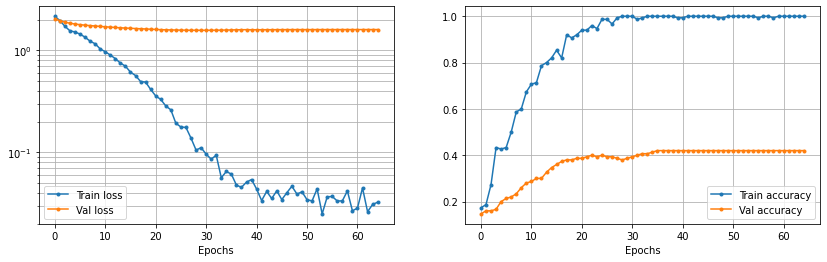

In [17]:
%%time
epochs = 200
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_1 = model_1.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_1)

#### ii) Modelo congelado

In [18]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_2 = Model(i, x)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 19.7 s, sys: 1.61 s, total: 21.3 s
Wall time: 52.5 s


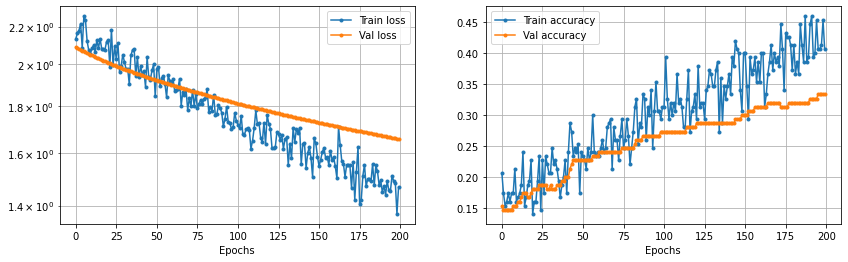

In [19]:
%%time
epochs = 200
lr = 1e-5
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_2 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_2)

#### iii) Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 1min 22s, sys: 2.39 s, total: 1min 24s
Wall time: 2min 2s


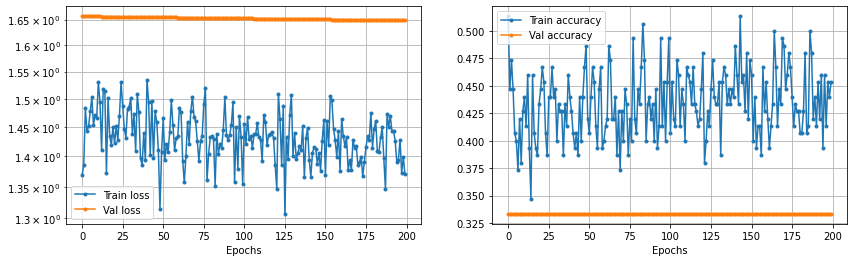

In [20]:
%%time
base_model.trainable = True

epochs = 200
lr = 1e-8
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_3 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_3)

### b) Com a utilização de data augmentation

In [21]:
# Camada de data augmentation
data_augmentation = Sequential(
  [
    RandomTranslation(height_factor=0.15, width_factor=0.15),
    RandomFlip(mode='horizontal')
  ],
  name='data_augmentation',
)

#### i) Modelo descongelado
```



In [22]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_3 = Model(i, x)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 2min 2s, sys: 15.8 s, total: 2min 18s
Wall time: 2min 7s


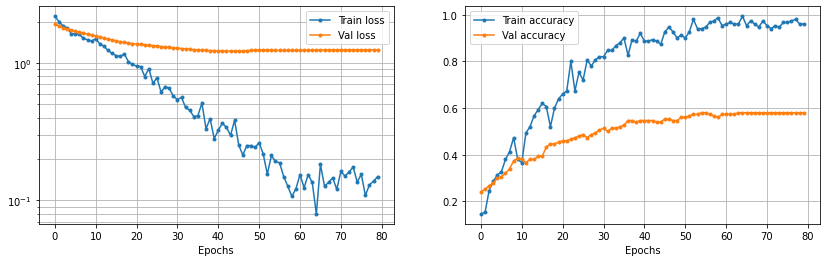

In [23]:
%%time
epochs = 200
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_4 = model_3.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_4)

#### Modelo congelado

In [24]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_4 = Model(i, x)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 3min 53s, sys: 38.3 s, total: 4min 32s
Wall time: 4min 22s


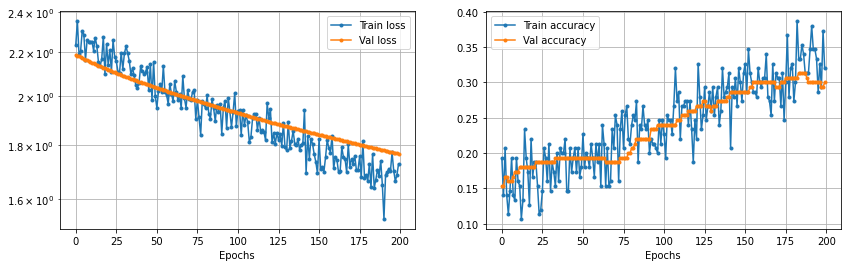

In [25]:
%%time
epochs = 200
lr = 1e-5

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_5 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_5)

#### Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 4min 50s, sys: 41.4 s, total: 5min 31s
Wall time: 4min 23s


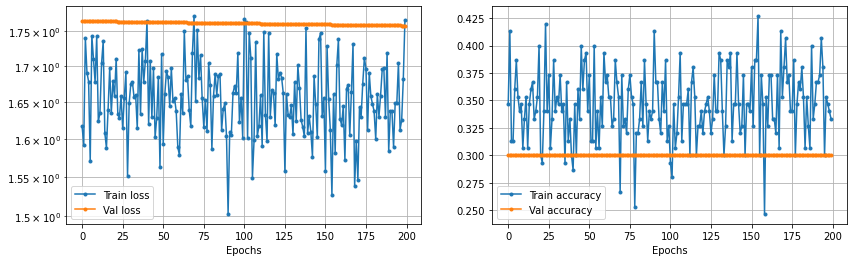

In [26]:
%%time
base_model.trainable = True

epochs = 200
lr = 1e-8

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_6 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_6)

## Treinamento com dataset de treinamento completo

#### **Baseline**

In [27]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 80, 80, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 80, 80, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294 

0epoch [00:00, ?epoch/s]

CPU times: user 59.5 s, sys: 1.59 s, total: 1min 1s
Wall time: 3min 49s


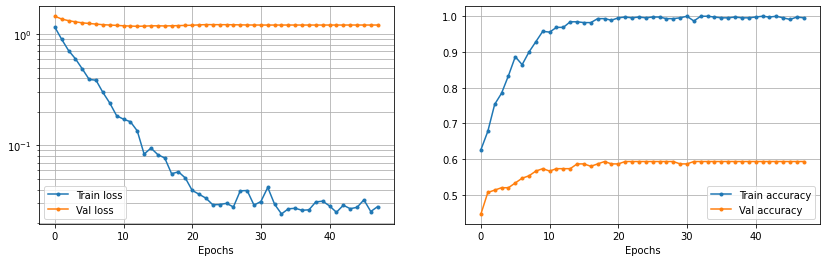

In [28]:
%%time
epochs = 200
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_7 = model_1.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_7)

#### Data augmentation

In [29]:
model_3

0epoch [00:00, ?epoch/s]

CPU times: user 4min 20s, sys: 38.1 s, total: 4min 58s
Wall time: 4min 12s


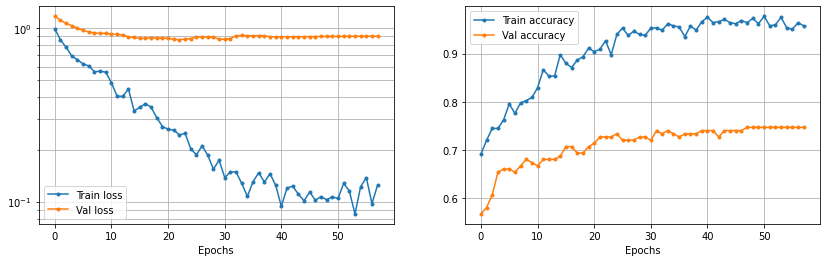

In [30]:
%%time
epochs = 200
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_8 = model_3.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_8)

#### Alteração do tamanho da imagem

In [31]:
new_img_size = (200, 200)
batch_size = 64

ds_train_r = create_dataset(df_train, new_img_size, batch_size)
ds_val_r = create_dataset(df_val, new_img_size, batch_size)
ds_test_r = create_dataset(df_test, new_img_size, batch_size)

In [32]:
input_shape = new_img_size + (3,) # (150, 150, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_5 = Model(i, x)

model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 6min 2s, sys: 11 s, total: 6min 13s
Wall time: 8min 48s


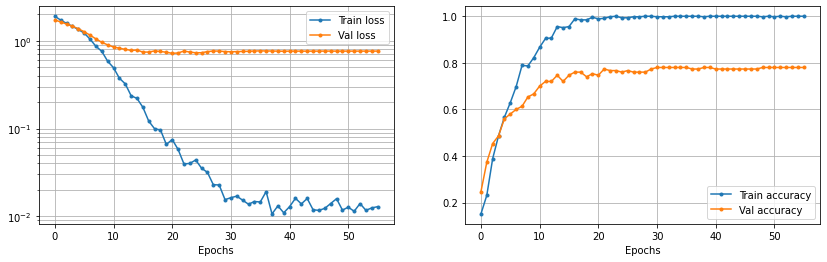

In [33]:
%%time
epochs = 200
lr = 1e-5

model_5.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_9 = model_5.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_9)

#### ResNet

In [34]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_6 = Model(i, x)

model_6.summary()

219055592/219055592 [==============================] - 15s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 1536)              0 

0epoch [00:00, ?epoch/s]

CPU times: user 1min 16s, sys: 6.03 s, total: 1min 22s
Wall time: 1min 50s


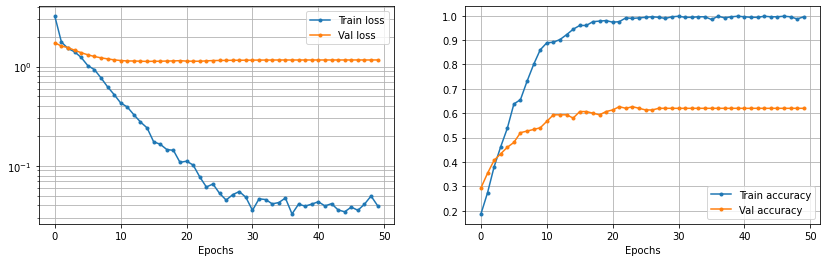

In [35]:
%%time
epochs = 200
lr = 1e-5

model_6.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_10 = model_6.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_10)

#### Data augmentation + alteração no tamanho da imagem

In [36]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_7 = Model(i, x)

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 9min 47s, sys: 48.8 s, total: 10min 36s
Wall time: 13min 48s


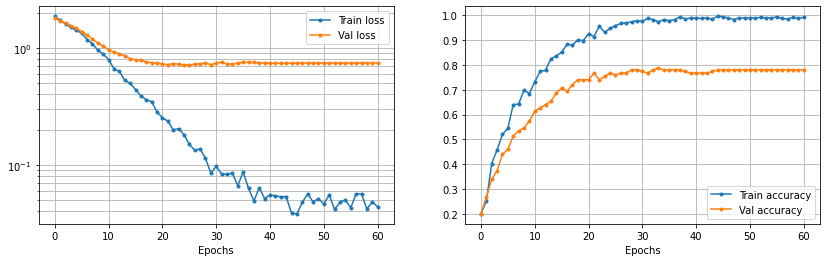

In [37]:
%%time
epochs = 200
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_11 = model_7.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_11)

#### Data augmentation + Resnet

In [38]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_8 = Model(i, x)

model_8.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                     

0epoch [00:00, ?epoch/s]

CPU times: user 4min 41s, sys: 45.5 s, total: 5min 26s
Wall time: 4min 31s


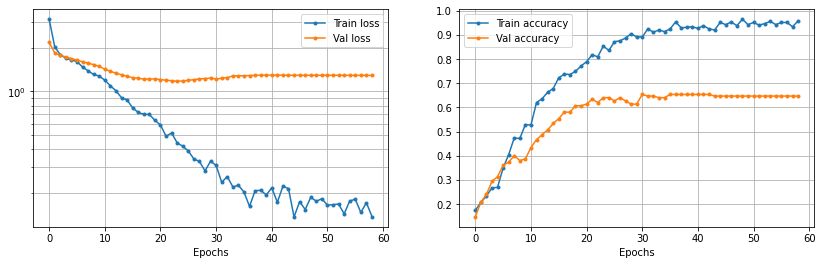

In [39]:
%%time
epochs = 200
lr = 1e-5
model_8.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_12 = model_8.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_12)

#### Alteração no tamanho da imagem + ResNet

In [40]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_9 = Model(i, x)

model_9.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 1536)              0         
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 3min 7s, sys: 1min 18s, total: 4min 25s
Wall time: 6min 26s


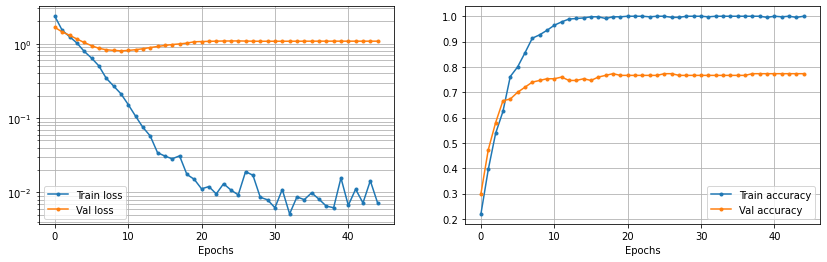

In [41]:
%%time
epochs = 200
lr = 1e-5

model_9.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_13 = model_9.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_13)

#### Data augmentation + alteração no tamanho da imagem + ResNet

In [42]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_10 = Model(i, x)

model_10.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                     

0epoch [00:00, ?epoch/s]

CPU times: user 6min 22s, sys: 2min 1s, total: 8min 23s
Wall time: 8min 39s


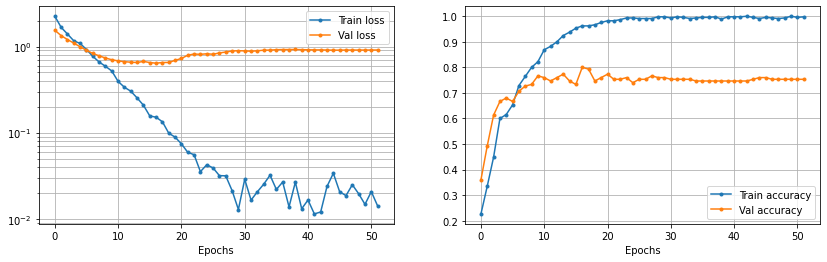

In [43]:
%%time
epochs = 200
lr = 1e-5

model_10.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_14 = model_10.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_14)

## Retreinamento (train + val)

In [44]:
# Dataset de treinamento + val
ds_retr = create_dataset(pd.concat([df_train, df_val], ignore_index=True), new_img_size, batch_size)

0epoch [00:00, ?epoch/s]

CPU times: user 21min, sys: 1min 43s, total: 22min 43s
Wall time: 28min 15s


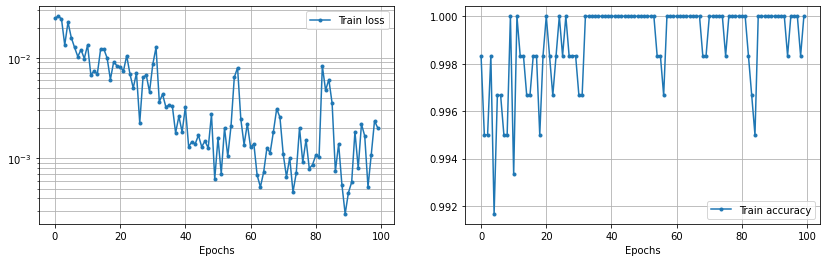

In [47]:
# Melhor modelo: data augmentation + alteração no tamanho da imagem (utilizando Xception) - "model_7"
%%time

epochs = 100
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_retr = model_7.fit(ds_retr, epochs=epochs, callbacks=[TqdmCallback(verbose=0)], verbose=0)

plots(history_retr)

## Análise de resultados (test)

### Matriz de confusão (test)


In [46]:
test_pred = model_7.predict(ds_test_r) # Predição das imagens com o melhor modelo - "model-7"

cm = confusion_matrix(test_true, test_pred) # Matriz de confusão
print("matriz de confusão")
print(cm)

3/3 [==============================] - 57s 15s/step


ValueError: ignored

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Acurácia individual de cada objeto
print ("cardboard  glass  metal  paper	plastic  trash")
acc = (TP+TN)/(TP+FP+FN+TN)
print(acc)

In [ ]:
# Gráfico para melhor interpretação da matriz de confusão
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

plot_confusion_matrix(cm, classes)

### Classificações erradas (test)